In [86]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-bright')
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import process
import pickle



C:\Users\tranm\AppData\Local\Temp\ipykernel_37388\336502684.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-bright')


In [87]:
path = '../Data'
movies = pd.read_csv(path + '/movies_metadata.csv')
credits = pd.read_csv(path + '/credits.csv')
keywords = pd.read_csv(path + '/keywords.csv')
ratings = pd.read_csv(path + '/ratings_small.csv')
links_small = pd.read_csv(path + '/links_small.csv')
links= pd.read_csv(path +'/links.csv')

C:\Users\tranm\AppData\Local\Temp\ipykernel_37388\2634989431.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies = pd.read_csv(path + '/movies_metadata.csv')


In [88]:
#Tệp siêu dữ liệu phim chính. Chứa thông tin về 45.000 phim có trong bộ dữ liệu Full MovieLens.
# Các tính năng bao gồm áp phích(adult), phông nền(belongs_to_collection), ngân sách, doanh thu, ngày phát hành, ngôn ngữ, quốc gia sản xuất và công ty
movies.head(1)



,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0


In [89]:
#Bao gồm thông tin về diễn viên và đoàn làm phim cho tất cả các bộ phim của chúng tôi. Có sẵn ở dạng Đối tượng JSON được xâu chuỗi.
credits.head(1)

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862


In [90]:
#Chứa từ khóa cốt truyện phim cho phim MovieLens của chúng tôi. Có sẵn ở dạng Đối tượng JSON được xâu chuỗi.
keywords.head(1)

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."


In [91]:
#Tập hợp con gồm 100.000 xếp hạng từ 700 người dùng trên 9.000 bộ phim.
ratings.head(1)

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144


In [92]:
#Chứa ID TMDB và IMDB của một tập hợp con nhỏ gồm 9.000 phim của Bộ dữ liệu đầy đủ.
links_small.head(1)

,movieId,imdbId,tmdbId
0,1,114709,862.0


In [93]:
#Tệp chứa ID TMDB và IMDB của tất cả các phim có trong bộ dữ liệu Full MovieLens
# tệp này cg  ko cần lắm 

links.head(1)

,movieId,imdbId,tmdbId
0,1,114709,862.0


In [94]:
movie_names = movies[['title', 'genres','id']]
movie_names.head(2)

,title,genres,id
0,Toy Story,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862
1,Jumanji,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844


In [95]:
ratings_data = ratings.drop('timestamp', axis = 1)
ratings_data.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


In [96]:
movie_names.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   45460 non-null  object
 1   genres  45466 non-null  object
 2   id      45466 non-null  object
dtypes: object(3)
memory usage: 1.0+ MB


In [97]:
movie_data = pd.concat([ratings_data, movie_names], axis=1)
movie_data.head()

,userId,movieId,rating,title,genres,id
0,1,31,2.5,Toy Story,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862
1,1,1029,3.0,Jumanji,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844
2,1,1061,3.0,Grumpier Old Men,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602
3,1,1129,2.0,Waiting to Exhale,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357
4,1,1172,4.0,Father of the Bride Part II,"[{'id': 35, 'name': 'Comedy'}]",11862


In [98]:
movie_data.isnull().sum()

userId         0
movieId        0
rating         0
title      54544
genres     54538
id         54538
dtype: int64

In [99]:
movie_data.head()

,userId,movieId,rating,title,genres,id
0,1,31,2.5,Toy Story,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862
1,1,1029,3.0,Jumanji,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844
2,1,1061,3.0,Grumpier Old Men,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602
3,1,1129,2.0,Waiting to Exhale,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357
4,1,1172,4.0,Father of the Bride Part II,"[{'id': 35, 'name': 'Comedy'}]",11862


In [100]:
trend = pd.DataFrame(movie_data.groupby('title')['rating'].mean())
trend['total number of ratings'] = pd.DataFrame(movie_data.groupby('title')['rating'].count()) 

trend.head()

,rating,total number of ratings
title,,
!Women Art Revolution,4.5,1
#1 Cheerleader Camp,5.0,1
#Horror,2.5,1
#chicagoGirl,1.0,1
"$1,000 on the Black",4.5,1


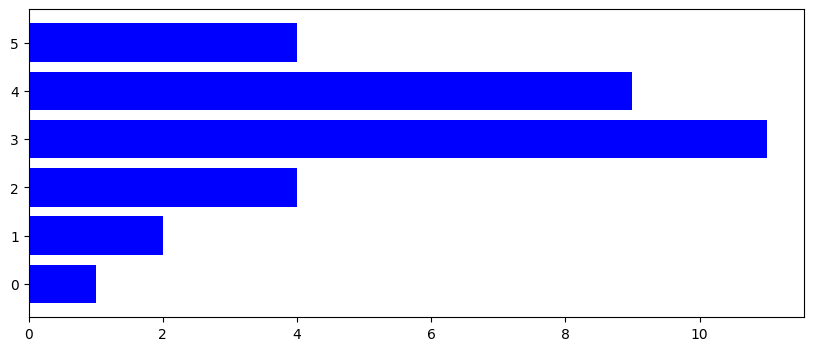

In [101]:
plt.figure(figsize =(10, 4))
ax=plt.barh(trend['rating'].round(),trend['total number of ratings'],color='b')
plt.show()

In [102]:
movie_data.groupby('title')['rating'].mean().sort_values(ascending=False).head(10)

title
Rapt                          5.0
My Sister's Kids in Africa    5.0
Nasu: Summer in Andalusia     5.0
Borderline Normal             5.0
Native Land                   5.0
Natsamrat                     5.0
Natural Born Killers          5.0
Natural City                  5.0
Naturally Native              5.0
Nature Calls                  5.0
Name: rating, dtype: float64

In [103]:
movies_users = ratings_data.pivot(index=['userId'], columns=['movieId'], values='rating').fillna(0)
movies_users

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
669,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [104]:
from scipy.sparse import csr_matrix
mat_movies_users=csr_matrix(movies_users.values)
mat_movies_users


<671x9066 sparse matrix of type '<class 'numpy.float64'>'
	with 100004 stored elements in Compressed Sparse Row format>

In [105]:

pickle.dump(mat_movies_users,open("movies_model_knn.pkl","wb"))
pickle.dump(movie_names,open("movie_name.pkl","wb"))

In [106]:
model_knn= NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)

In [107]:
model_knn.fit(mat_movies_users)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [120]:
def Recommender(movie_name, data, model, n_recommendations):
    model.fit(data)
    movie_index = process.extractOne(movie_name, movie_names['title'])[2]
    print('Movie Selected: ',movie_names['title'][movie_index], ', Index: ', movie_index)
    print('Searching for recommendations.....')
    distances, indices = model.kneighbors(data[movie_index], n_neighbors=n_recommendations)
    recc_movie_indices = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())),key=lambda x: x[1])[:0:-1]
    recommend_frame = []
    for val in recc_movie_indices:
#         print(movie_names['title'][val[0]])
        recommend_frame.append({'Title':movie_names['title'][val[0]],'Distance':val[1],'id':movie_names['id'][val[0]]})
    
    df = pd.DataFrame(recommend_frame, index = range(1,n_recommendations))
     
    return df

In [121]:
movie_names.head(10)

,title,genres,id
0,Toy Story,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862
1,Jumanji,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844
2,Grumpier Old Men,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602
3,Waiting to Exhale,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357
4,Father of the Bride Part II,"[{'id': 35, 'name': 'Comedy'}]",11862
5,Heat,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",949
6,Sabrina,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",11860
7,Tom and Huck,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",45325
8,Sudden Death,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",9091
9,GoldenEye,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",710


In [123]:
n_recommendations = 100
Recommender('Toy Story', mat_movies_users, model_knn, n_recommendations)

Movie Selected:  Toy Story , Index:  0
Searching for recommendations.....


,Title,Distance,id
1,Screamers,0.949445,9102
2,The Road to Wellville,0.949256,10467
3,The Secret Garden,0.949199,11236
4,The Piano,0.949045,713
5,Party Girl,0.948246,36196
...,...,...,...
95,White Man's Burden,0.847254,31611
96,The Swan Princess,0.842476,22586
97,"The Adventures of Priscilla, Queen of the Desert",0.837181,2759
98,Roula,0.805907,398959
